#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

os.chdir(r'/projappl/project_2000908/nousu/SpaFHy_v2.0')

# example of calling driver, reading results
outputfile = driver(create_ncf=True, create_spinup=False, folder='testcase_input')
results = xr.open_dataset(outputfile)

{1.0, 2.0, 3.0, 4.0} {1.0, 2.0, 4.0, nan}
*** State variables assigned from parameters.py ***
*** Simulation forced with: /projappl/project_2000908/nousu/SpaFHy_FORCING/HYYTIALA_FORCING_1980_2021.csv


/projappl/project_2000908/nousu/SpaFHy_v2.0/canopygrid.py:761: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


*** Running model ***
*** TOPMODEL run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Running timestep:  2
Running timestep:  3
Running timestep:  4
Running timestep:  5
Running timestep:  6


/projappl/project_2000908/nousu/SpaFHy_v2.0/canopygrid.py:688: RuntimeWarning: divide by zero encountered in divide
  rb = 1. / LAI * beta * ((w / Uh)*(alpha / (1.0 - np.exp(-alpha / 2.0))))**0.5


Running timestep:  7
Running timestep:  8
Running timestep:  9
Running timestep:  10
Running timestep:  11
Running timestep:  12
Running timestep:  13
Running timestep:  14
Running timestep:  15
Running timestep:  16
Running timestep:  17
Running timestep:  18
Running timestep:  19
Running timestep:  20
Running timestep:  21
Running timestep:  22
Running timestep:  23
Running timestep:  24
Running timestep:  25
Running timestep:  26
Running timestep:  27
Running timestep:  28
Running timestep:  29
Running timestep:  30
Running timestep:  31
Running timestep:  32
Running timestep:  33
Running timestep:  34
Running timestep:  35
Running timestep:  36
Running timestep:  37
Running timestep:  38
Running timestep:  39
Running timestep:  40
Running timestep:  41
Running timestep:  42
Running timestep:  43
Running timestep:  44
Running timestep:  45
Running timestep:  46
Running timestep:  47
Running timestep:  48
Running timestep:  49
Running timestep:  50
Running timestep:  51
Running times

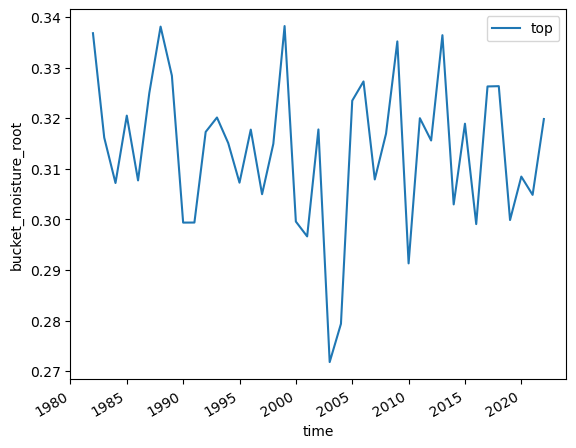

In [3]:
results['bucket_moisture_root'].resample(time='A').mean().mean(dim=['lat','lon']).plot(label='top')
plt.legend()

In [7]:
firedata = results[['parameters_soilclass','forcing_wind_speed', 'forcing_air_temperature', 'forcing_relative_humidity', 'bucket_moisture_root', 'bucket_moisture_top']].copy()
firedata['bucket_water_potential_root'] = results['bucket_moisture_root'].copy()

In [48]:
from soilprofile2D import wrc
from parameters import soilprofiles
soilprofiles()['CoarseTextured']['pF']

{'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}

In [ ]:
soil_id = np.ravel(firedata['parameters_soilclass'])
psi = []       
for time in firedata['time'][0:5]:
    rootmoist = np.ravel(firedata['bucket_moisture_root'])
    for soil in soilprofiles().keys():
        pF_temp = soilprofiles()[soil]['pF']
        id = soilprofiles()[soil]['soil_id']
        psi.append(wrc(theta=rootmoist[soil_id == id], pF=pF_temp))

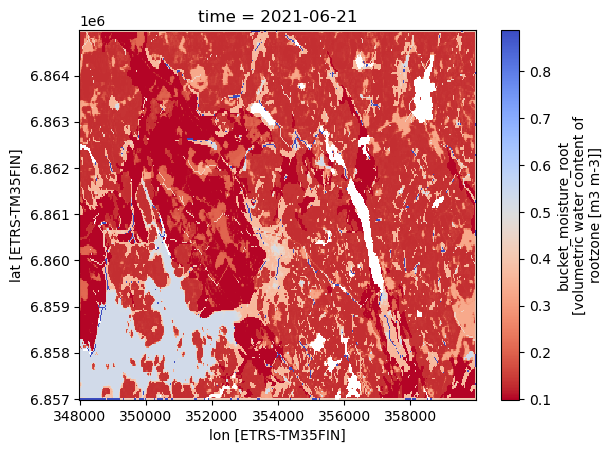

In [4]:
day = '2021-06-21'
results['bucket_moisture_root'].sel(time=day).plot(cmap='coolwarm_r')

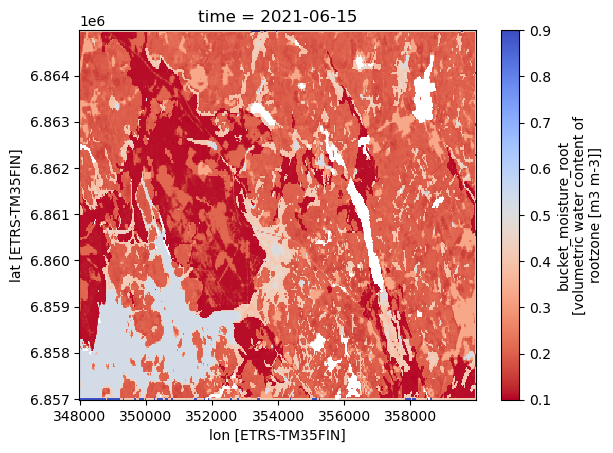

In [11]:
results['bucket_moisture_root'].sel(time='2021-06-15').plot(vmin=0.1, vmax=0.9, cmap='coolwarm_r')

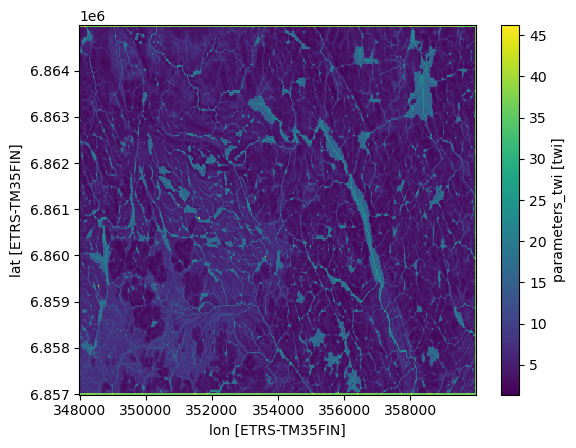

In [5]:
results['parameters_twi'].plot()

In [65]:
from typing import Dict, List, Tuple

def wrc(pF, theta=None, psi=None, draw_pF=False):
    """
    vanGenuchten-Mualem soil water retention model 

    References:
        Schaap and van Genuchten (2005). Vadose Zone 5:27-34
        van Genuchten, (1980). Soil Science Society of America Journal 44:892-898

    Args:
        pF (dict):
            ThetaS (float|array): saturated water content [m3 m-3]
            ThetaR (float|array): residual water content [m3 m-3]
            alpha (float|array): air entry suction [cm-1]
            n (float|array): pore size distribution [-]
        theta (float|array): vol. water content [m3 m-3]
        psi (float|array): water potential [m]
        draw_pF (bool): Draw pF-curve.
    Returns:
        y (float|array): water potential [m] or vol. water content [m3 m-3]. Returns None if only curve is drawn.

    """
    
    EPS = np.finfo(float).eps
    
    Ts = np.array([pF['ThetaS']])
    Tr = np.array([pF['ThetaR']])
    alfa = np.array([pF['alpha']])
    n = np.array([pF['n']])
    m = 1.0 - np.divide(1.0, n)

    mask = 
    
    def theta_psi(x):
        # converts water content [m3 m-3] to potential [m]]
        x = np.minimum(x, Ts)
        x = np.maximum(x, Tr)  # checks limits
        s = (Ts - Tr) / ((x - Tr) + EPS)
        Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
        Psi[np.isnan(Psi)] = 0.0
        return Psi

    def psi_theta(x):
        # converts water potential [m] to water content [m3 m-3]
        x = 100*np.minimum(x, 0)  # cm
        Th = Tr + (Ts - Tr) / (1 + abs(alfa*x)**n)**m
        return Th

    # --- convert between theta <-- --> psi
    if (theta != None).any():
        y = theta_psi(theta)  # 'Theta-->Psi'
    elif (psi != None).any():
        y = psi_theta(psi)  # 'Psi-->Theta'

    # draws pf-curve
    if draw_pF:
        Ts = Ts[0]; Tr = Tr[0]; alpha = alfa[0]; n = n[0]  
        xx = -np.logspace(-4, 5, 100)  # cm
        yy = psi_theta(xx)

        #  field capacity and wilting point
        fc = psi_theta(-1.0)
        wp = psi_theta(-150.0)

        fig = plt.figure(99)
        fig.suptitle('vanGenuchten-Mualem WRC', fontsize=16)
        ttext = r'$\theta_s=$' + str(Ts) + r', $\theta_r=$' + str(Tr) +\
                r', $\alpha=$' + str(alfa) + ',n=' + str(n)

        plt.title(ttext, fontsize=14)
        plt.semilogx(-xx, yy, 'g-')
        plt.semilogx(1, fc, 'ro', 150, wp, 'ro')  # fc, wp
        plt.text(1, 1.1*fc, 'FC'), plt.text(150, 1.2*wp, 'WP')
        plt.ylabel(r'$\theta$  $(m^3m^{-3})$', fontsize=14)
        plt.xlabel('$\psi$ $(m)$', fontsize=14)
        plt.ylim(0.8*Tr, min(1, 1.1*Ts))

        del xx, yy
        y = None
    
    return y

In [67]:
pF1 = {'ThetaS': 0.43, 'ThetaR': 0.05, 'alpha': 0.024, 'n': 1.2}
pF2 = {'ThetaS': 0.88, 'ThetaR': 0.196, 'alpha': 0.072, 'n': 1.255}

theta = np.array([[0.2, 0.1], [0.3, np.nan]])

wrc(pF=pF1, theta=theta, draw_pF=False)

TypeError: only integer scalar arrays can be converted to a scalar index

In [50]:
theta.exists

AttributeError: 'numpy.ndarray' object has no attribute 'exists'

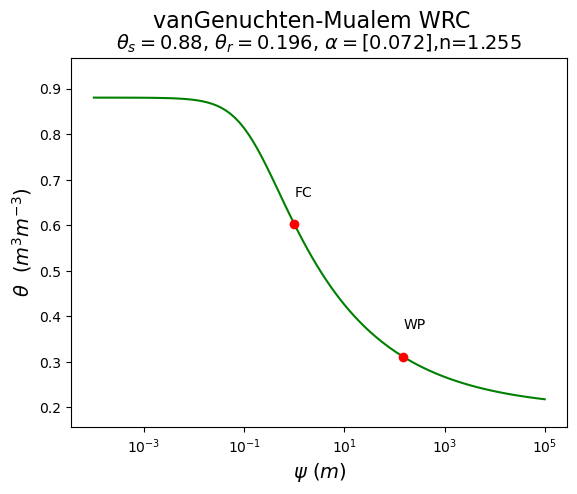